# Loan Default Predictor

## Goal:
To predict the probability of default of a loan over its life. 

## Data used: 
1.	2012 – 2013 Loan Status data downloaded from LendingClub<br>
2.	interest rate.csv: treasury bond coupon rate between 2011 and 2017, as a way to indicate general economic situation and cost of credit


In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC

from sklearn.grid_search import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn import model_selection, preprocessing
from sklearn.metrics import roc_auc_score, roc_curve

In [ ]:
loan = pd.read_csv(r'Loan Predictor/LoanStats3b.csv') # (188181, 137)
treasury = pd.read_csv(r'Loan Predictor/interest rate.csv')
loan = loan[loan['term'] == ' 36 months'].reset_index(drop = True) # (143892, 137)

### Read files
Remove data that's not 36 months term

###  Data processing
1>  convert dates <br> 2> convert strings to numbers<br> 3> convert categorical strings to coding integers<br>4> use treasury rate as a feature based on the issue date

In [4]:
loan['issue_d'] = loan['issue_d'].apply(lambda date: pd.to_datetime('-'.join(['20' + date.split('-')[1],date.split('-')[0]])))
loan['earliest_cr_line'] = loan['earliest_cr_line'].apply(lambda date: pd.to_datetime('-'.join(['20' + date.split('-')[1],date.split('-')[0]])))

loan['num_days_since_1st_issue'] = (loan['issue_d'] - min(loan['issue_d'])).dt.days 
loan['issue_m'] = [x.month for x in loan['issue_d']]
loan['num_days_since_1st_cr_line'] = (loan['earliest_cr_line'] - min(loan['earliest_cr_line'])).dt.days 


In [5]:
loan['int_rate'] = loan['int_rate'].apply(lambda percent: np.nan if pd.isnull(percent) else float(percent.strip('%')) / 100)
loan['revol_util'] = loan['revol_util'].apply(lambda percent: np.nan if pd.isnull(percent) else float(percent.strip('%')) / 100)

loan['emp_length'] = loan['emp_length'].apply(lambda x: x[0:2])
loan['emp_length'] = loan['emp_length'].replace({'n/': np.nan, '< ':0.5}).astype(np.float)

In [6]:
loan["loan_status"] = loan["loan_status"].replace({'Fully Paid': 0, 'Charged Off':1})

# feature expansions to include more dummy variables
# tried between one hot encoding and lable encoding - results are not significant either way 
#loan = pd.concat([loan, pd.get_dummies(loan["verification_status"])], axis=1)
#loan = pd.concat([loan, pd.get_dummies(loan["home_ownership"])], axis=1)
#loan = pd.concat([loan, pd.get_dummies(loan["purpose"])], axis=1)

loan["purpose_cat"] = loan["purpose"].astype('category').cat.codes
loan["verification_status_cat"] = loan["verification_status"].astype('category').cat.codes
loan["home_ownership_cat"] = loan["home_ownership"].astype('category').cat.codes

In [7]:
treasury['date'] = pd.to_datetime(treasury['date'])
loan = pd.merge(loan, treasury, how='left', left_on=['issue_d'],right_on=['date'])

33% of default ==> imbalanced binary classes ==> AUC would be the best to quantity accuracy

In [8]:
loan['loan_status'].std()

0.33302640632455505

### Feature selection based on column types and data quality

1> remove columns where there are more than 20% data missing <br> 2> Unfortunately Python RF doesn't take date columns or string columns. Seperate numeric columns from non-numeric columns - each category was mannually examed to decide which columns to include/exclude/transform

In [9]:
null_ratio = loan.isnull().sum() / loan.shape[0]
non_null_columns = null_ratio[null_ratio < 0.2].index #86
numeric_columns = loan[non_null_columns]._get_numeric_data().columns #66
non_numeric_columns = list(set(non_null_columns) - set(numeric_columns)) #20

### Remove features that are considered 'hindsight information'. Keep only columns that were available at the time of loan issuance minus grade/sub grade

In [10]:
hindsight_columns = ['last_pymnt_amnt','total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
                     'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
                     'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
                     'chargeoff_within_12_mths', 'delinq_amnt',
                     'policy_code', 'out_prncp', 'out_prncp_inv'] # the last 3 columns have the same number throughout, therefore providing no information

ML_columns = list(set(numeric_columns)-set(hindsight_columns))
non_na_data = loan[ML_columns].dropna() #97345

X = non_na_data.drop('loan_status',axis = 1)
Y = non_na_data['loan_status']
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size=0.3)

### ML1 - Random Forest
parameters were tuned using GridSearchCV

In [11]:
parameters={'max_depth': [18],
            'min_samples_leaf': [60],
            'min_samples_split' : [50]}

rf_search = GridSearchCV(RandomForestClassifier(), parameters, scoring = 'roc_auc')

rf_search.fit(X_train, Y_train)
print (rf_search.best_score_)
print (rf_search.best_params_)

0.6569303415075218
{'max_depth': 18, 'min_samples_leaf': 60, 'min_samples_split': 50}


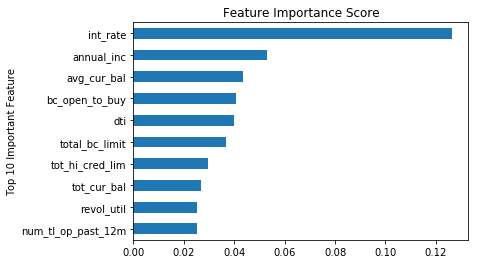

In [12]:
rf = rf_search.best_estimator_

feat_imp = pd.Series(rf.feature_importances_, X.columns).sort_values(ascending=True)
feat_imp[-10:].plot(kind='barh', title='Feature Importance Score')
plt.ylabel('Top 10 Important Feature')

In [13]:
proba_default = rf.predict_proba(X_test)[:, 1]
accuracy = rf.score(X_test, Y_test)
auc =  roc_auc_score(Y_test, proba_default)

print ("Accuracy: %0.4f" %accuracy)
print ("ROC Curve: %0.4f" %auc)

Accuracy: 0.8773
ROC Curve: 0.6484


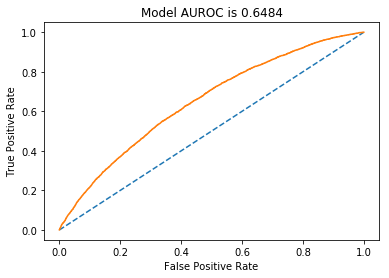

In [14]:
false_positive, true_positive, _ = roc_curve(Y_test, proba_default)
plt.plot(false_positive, false_positive, linestyle='--')
plt.plot(false_positive, true_positive)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Model AUROC is %0.4f' %auc)

### ML2 - Gaussian Naive Bay

In [15]:
pipeline = Pipeline(steps=[('standardize', preprocessing.StandardScaler()),('model', GaussianNB())])

gnb_search = GridSearchCV(estimator=pipeline, param_grid=dict(), scoring = 'roc_auc')

gnb_search.fit(X_train, Y_train)

print(" The gnb best_score is : ", gnb_search.best_score_)

gnb = gnb_search.best_estimator_
accuracy = gnb.score(X_test, Y_test)
print ("Accuracy: %0.4f" %accuracy)

 The gnb best_score is :  0.6327341475330825
Accuracy: 0.6005


### ML3 - Linear SVC
parameters were tuned using GridSearchCV

In [16]:
pipeline = Pipeline(steps=[('standardize', preprocessing.StandardScaler()),('model', LinearSVC()) ])

parameters={'model__class_weight': ['balanced'],
            'model__loss': [ 'hinge'],
            'model__max_iter' : [1400]}

svc_search = GridSearchCV(estimator=pipeline, param_grid = parameters, scoring = 'roc_auc')

svc_search.fit(X_train, Y_train)

print(svc_search.best_estimator_)
print(" The svc best_score is : ", svc_search.best_score_)

svc = svc_search.best_estimator_
accuracy = svc.score(X_test, Y_test)
print ("Accuracy: %0.4f" %accuracy)

Pipeline(steps=[('standardize', StandardScaler(copy=True, with_mean=True, with_std=True)), ('model', LinearSVC(C=1.0, class_weight='balanced', dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1400, multi_class='ovr',
     penalty='l2', random_state=None, tol=0.0001, verbose=0))])
 The svc best_score is :  0.6700532465250943
Accuracy: 0.5997
